In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
top24 = pd.read_csv('/Users/I566184/bachelorarbeit_coding/mesogeos/csv/Top_24_Summed_Variables.csv')
rf = pd.read_csv('/Users/I566184/bachelorarbeit_coding/mesogeos/csv/FeatureImportance-RF.csv')

In [4]:
top24.columns

Index(['Variable', 'Total_Importance'], dtype='object')

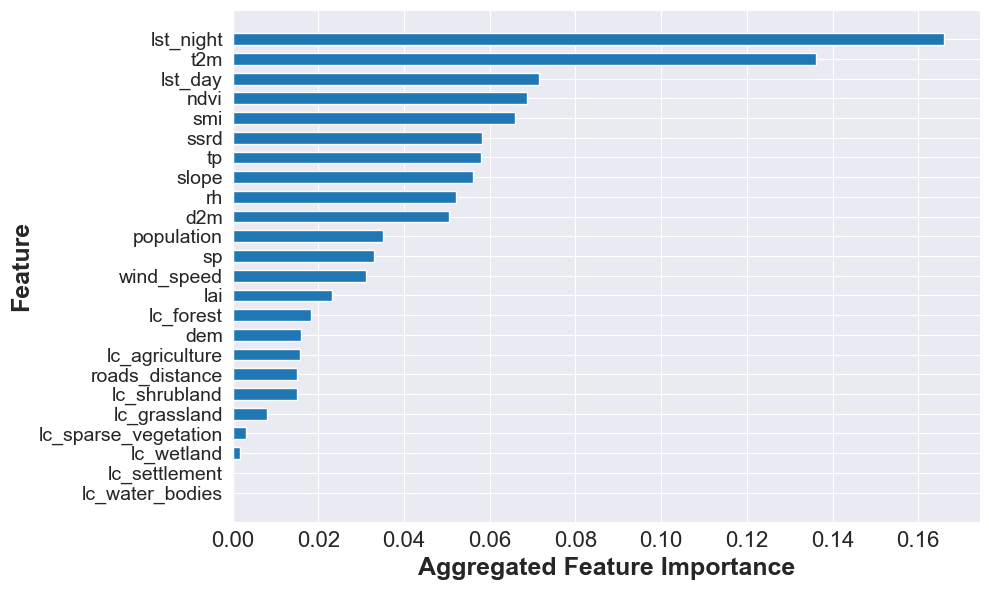

In [16]:
top24_sorted = top24.sort_values(by='Total_Importance', ascending=False)

# Barplot erstellen
plt.figure(figsize=(10, 6))
plt.barh(top24_sorted['Variable'], top24_sorted['Total_Importance'], height=0.6)


# Achsenbeschriftungen fett und groß
plt.xlabel('Aggregated Feature Importance', fontsize=18, fontweight='bold')
plt.ylabel('Feature', fontsize=18, fontweight='bold')
# Wichtigste Features oben anzeigen
plt.gca().invert_yaxis()

# Achsenticks größer machen
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
rf

,Variable,Importance
0,t2m_lag29,0.0204
1,t2m_lag28,0.0200
2,lst_night_lag29,0.0184
3,t2m_lag27,0.0158
4,lst_night_lag28,0.0154
...,...,...
715,lc_water_bodies_lag11,0.0000
716,lc_water_bodies_lag16,0.0000
717,lc_water_bodies_lag0,0.0000
718,lc_water_bodies_lag18,0.0000


In [ ]:
quartil = [0.1, 0.25, 0.5, 0.75, 0.95, 0.99]
for q in quartil:
    sum = 0
    i = 0
    while (sum + top24['Total_Importance'][i]) < q:
        sum +=  top24['Total_Importance'][i]
        i += 1
    print(f"{q*100}% der besten Feature durch {i} Features erreicht.")

for i in range(len(top24)):
    print(f"Variable {top24['Variable'][i]} hat eine Wichtigkeit von {top24['Total_Importance'][i]}")
